In [229]:
import tensorflow as tf
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras import layers
#from keras.layers import BatchNormalization
from keras.models import Model
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

In [230]:
# mount your Google drive so that you only have to download the data only once
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [231]:
######load your data#######
import os
from os import walk
import numpy as np
# load your data
paths = ["/content/drive/MyDrive/SampledGuitar/Stratocaster/BluesDriver",
         "/content/drive/MyDrive/SampledGuitar/Stratocaster/Chorus",
         "/content/drive/MyDrive/SampledGuitar/Stratocaster/Clean",
         "/content/drive/MyDrive/SampledGuitar/Stratocaster/Digital Delay",
         "/content/drive/MyDrive/SampledGuitar/Stratocaster/Flanger",
         "/content/drive/MyDrive/SampledGuitar/Stratocaster/Phaser",
         "/content/drive/MyDrive/SampledGuitar/Stratocaster/RAT",
         "/content/drive/MyDrive/SampledGuitar/Stratocaster/Sweep Echo",
         "/content/drive/MyDrive/SampledGuitar/Stratocaster/TapeEcho",
         "/content/drive/MyDrive/SampledGuitar/Stratocaster/TubeScreamer"
         ]
#print(paths)
audios = []
labels = []
labelsname = []
for i in paths:
    for (dirpath, dirnames, filenames) in walk(i):
      for directory in dirpath:
        for filename in filenames:
            audios.append(os.path.join(dirpath, filename))
        #print(filenames)
        #audios.append(filenames)
        break


In [ ]:
print(len(audios))

6901


In [232]:
###rawwaveform
import librosa
import numpy as np

waveforms = []
#nsr = 22050

for track in audios[:690*2]:
  if track.endswith("wav"):
    y,fs = librosa.load(track)
    waveforms.append(librosa.resample(y[:48000],48000,16000))

#data = np.array(data)
#datastft = np.array(datastft)
waveforms = np.array(waveforms)

#print(data.shape)
#print(datastft.shape)
print(waveforms.shape)

(1380, 16000)


In [245]:
###normalizar y cambio de dimensionalidad
mu_wave = np.mean(waveforms, axis= 1)[...,np.newaxis]
max_wave = np.max(waveforms, axis=1)[...,np.newaxis]

Xw = (waveforms-mu_wave)/max_wave
print(Xw.shape)

(1380, 16000)


In [246]:
#####reshape de los datos
Xw = Xw[...,np.newaxis][...,np.newaxis]
print(Xw.shape)

(1380, 16000, 1, 1)


In [235]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [236]:
class KLDivergenceRegularizer(tf.keras.regularizers.Regularizer):
  def __init__(self, iters: tf.Variable, warm_up_iters: int, latent_size: int):
    self._iters = np.array([iters])
    self._warm_up_iters = np.array([warm_up_iters])
    self.latent_size = latent_size
  
  @tf.function
  def __call__(self, activation):
    # note: activity regularizers automatically divide by batch size
    mu= activation[:self.latent_size]
    log_var = activation[self.latent_size:]
    k = np.min(self._iters / self._warm_up_iters)
    return -0.5 * k * K.sum(1 + log_var - K.square(mu) - K.exp(log_var))

In [237]:
warm_up_iters = 100
optimizer = tf.keras.optimizers.Adam(0.0001)


In [238]:
latent_dim = 128
original_dim = (16000, 1, 1)
encoder_inputs = keras.Input((16000, 1, 1))                                                   # bat, samps, ?, ch
x = layers.Conv2D(64, (33,1), activation="relu", padding="same",strides=(4,1))(encoder_inputs) # [69, 48000, 1, 1] -> [69, 12000, 1, 64]
x = layers.Conv2D(128,(33,1), activation="relu", padding="same",strides=(4,1))(x)
x = layers.Conv2D(256,(33,1), activation="relu", padding="same",strides=(4,1))(x)
latent = layers.Conv2D(512,(33,1), activation="relu", padding="same",strides=(3,1))(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
z_mean = layers.Dense(units=latent_dim, name='Z-Mean')(x) # Mean component
z_log_sigma = layers.Dense(units=latent_dim, name='Z-Log-Sigma')(x) # Standard deviation component
z_regular = tf.keras.layers.Concatenate(activity_regularizer= KLDivergenceRegularizer(optimizer.iterations, warm_up_iters,latent_dim))([z_mean,z_log_sigma])
z = Sampling()([z_mean, z_log_sigma])
#z_regular = tf.keras.layers.Concatenate(activity_regularizer=W_KLDivergenceRegularizer(optimizer.iterations,warmup_it,latent_dim))([z_mean,z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_sigma, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 16000, 1, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_80 (Conv2D)             (None, 4000, 1, 64)  2176        ['input_29[0][0]']               
                                                                                                  
 conv2d_81 (Conv2D)             (None, 1000, 1, 128  270464      ['conv2d_80[0][0]']              
                                )                                                                 
                                                                                            

In [239]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(250 * 1 * 256, activation="relu")(latent_inputs)
x = layers.Reshape((250, 1, 256))(x)
#x = layers.Conv2DTranspose(512,(4,1), activation="relu",padding= "same",strides= (3,1))(x)
x = layers.Conv2DTranspose(128,(33,1), activation="relu",padding= "same",strides= (4,1))(x)
x = layers.Conv2DTranspose(64,(33,1), activation="relu",padding= "same",strides= (4,1))(x)
#x = layers.Conv2DTranspose(64,(16,1), activation="relu",padding= "same",strides=(4,1))(x)
decoder_outputs = layers.Conv2DTranspose(1, (33, 1), activation="tanh", padding="same", strides = (4,1))(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 128)]             0         
                                                                 
 dense_29 (Dense)            (None, 64000)             8256000   
                                                                 
 reshape_8 (Reshape)         (None, 250, 1, 256)       0         
                                                                 
 conv2d_transpose_24 (Conv2D  (None, 1000, 1, 128)     1081472   
 Transpose)                                                      
                                                                 
 conv2d_transpose_25 (Conv2D  (None, 4000, 1, 64)      270400    
 Transpose)                                                      
                                                                 
 conv2d_transpose_26 (Conv2D  (None, 16000, 1, 1)      2113

In [240]:
# Define outputs from a VAE model by specifying how the encoder-decoder models are linked
outpt = decoder(encoder(encoder_inputs)[2]) # note, outputs available from encoder model are z_mean, z_log_sigma and z. We take z by specifying [2]
# Instantiate a VAE model
vae = Model(inputs=encoder_inputs, outputs=outpt, name='VAE-Model')
vae.compile(optimizer= optimizer,loss = 'mean_squared_error')

#vae.summary()

In [ ]:
vae.fit(Xw,Xw, shuffle = True, batch_size= 5, epochs= 200)

Epoch 1/200
276/276 [==============================] - 15s 55ms/step - loss: 0.0093
Epoch 2/200
276/276 [==============================] - 15s 54ms/step - loss: 0.0092
Epoch 3/200
276/276 [==============================] - 15s 54ms/step - loss: 0.0092
Epoch 4/200
276/276 [==============================] - 15s 54ms/step - loss: 0.0092
Epoch 5/200
276/276 [==============================] - 15s 54ms/step - loss: 0.0090
Epoch 6/200
276/276 [==============================] - 15s 54ms/step - loss: 0.0087
Epoch 7/200
276/276 [==============================] - 15s 54ms/step - loss: 0.0086
Epoch 8/200
276/276 [==============================] - 15s 54ms/step - loss: 0.0085
Epoch 9/200
276/276 [==============================] - 15s 54ms/step - loss: 0.0087
Epoch 10/200
276/276 [==============================] - 15s 54ms/step - loss: 0.0089
Epoch 11/200
276/276 [==============================] - 15s 54ms/step - loss: 0.0088
Epoch 12/200
276/276 [==============================] - 15s 54ms/step - lo

In [247]:
latent = encoder.predict(Xw)

In [252]:
print(latent[0].shape)

(1380, 128)


In [253]:
y_hat = vae.predict(Xw)

In [ ]:
print(y_hat[0].flatten())

[ 0.06339784 -0.37164238 -0.54849803 ... -0.511845   -0.6297051
 -0.7858862 ]


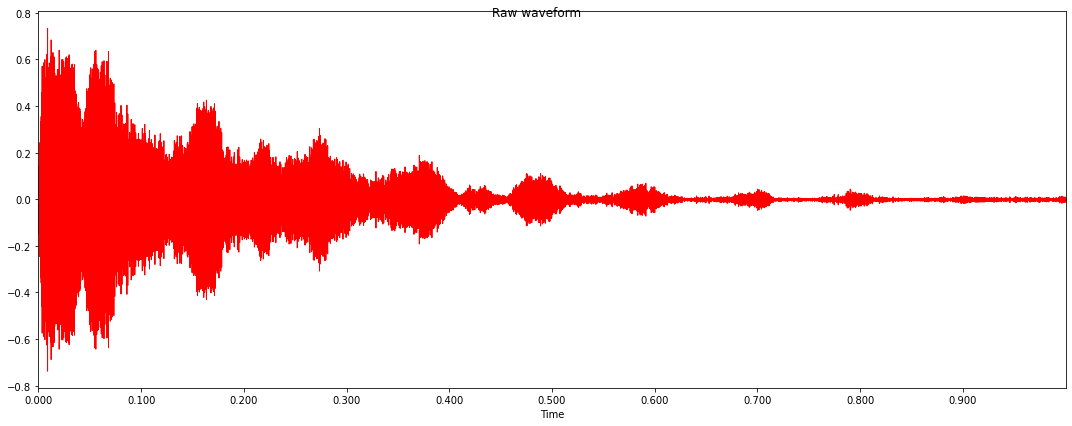

In [256]:
import matplotlib.pyplot as plt
import librosa.display
 
plt.figure(figsize=(15, 6)).suptitle("Raw waveform")
librosa.display.waveplot(y_hat[1000].flatten(),sr=16000, color='r')
plt.tight_layout()
plt.show()

In [257]:
import IPython
sr = 16000
IPython.display.Audio(y_hat[1000].flatten(), rate=sr)

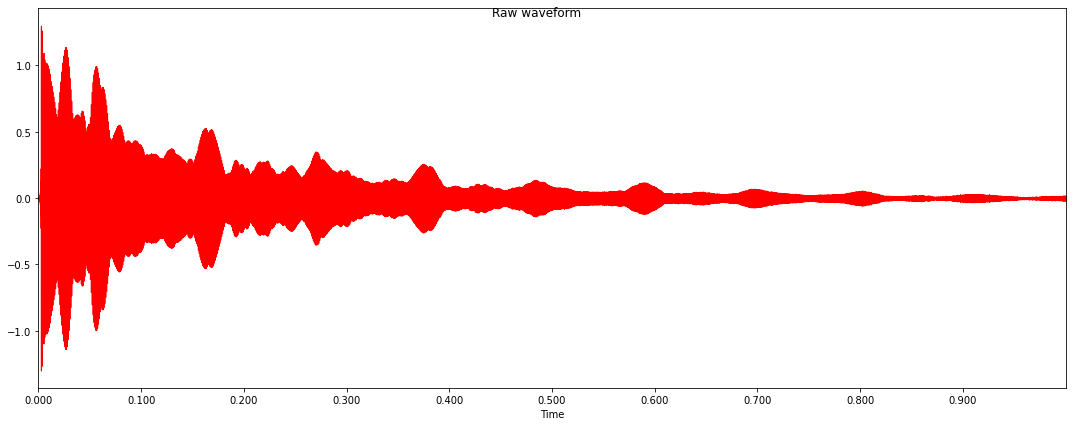

In [258]:
import matplotlib.pyplot as plt
import librosa.display

plt.figure(figsize=(15, 6)).suptitle("Raw waveform")
librosa.display.waveplot(Xw[1000].flatten(),sr=16000, color='r')
plt.tight_layout()
plt.show()

In [259]:
import IPython
sr = 16000
IPython.display.Audio(Xw[1000].flatten(), rate=sr)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


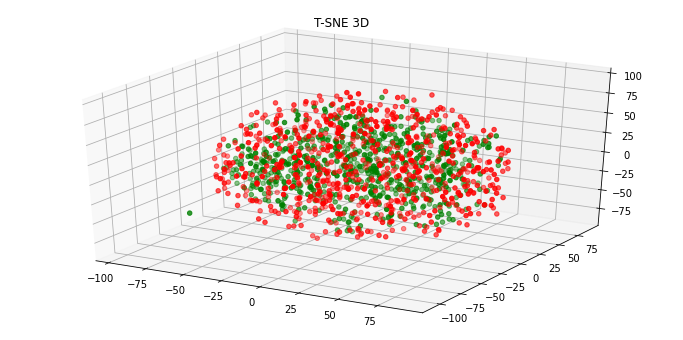

In [265]:
from sklearn.manifold import TSNE 

fig = plt.figure(1, figsize=(12, 6))
#a3x = Axes3D(fig,elev=-20, azim=100)
tsne = TSNE(n_components= 3)  # create an instance of t-SNE
ax = plt.axes(projection = "3d")
X_PCA = tsne.fit_transform(latent[0])  # fit and transform the data
ax.scatter3D(X_PCA[:689, 0], X_PCA[:689, 1],X_PCA[:689, 2], c='red', label='fx1')
ax.scatter3D(X_PCA[690:1379, 0], X_PCA[690:1379, 1],X_PCA[690:1379, 2], c='green', label='fx2')
#ax.scatter3D(X_PCA[1380:2069, 0], X_PCA[1380:2069, 1],X_PCA[1380:2069, 2], c='blue', label='fx3')
#ax.scatter3D(X_PCA[2070:2759, 0], X_PCA[2070:2759, 1],X_PCA[2070:2759, 2], c='red', label='fx4')
#ax.scatter3D(X_PCA[2760:3449, 0], X_PCA[2760:3449, 1],X_PCA[2760:3449, 2], c='yellow', label='fx5')
#ax.scatter3D(X_PCA[3450:4139, 0], X_PCA[3450:4139, 1],X_PCA[3450:4139, 2], c='black', label='fx6')
#ax.scatter3D(X_PCA[4140:4829, 0], X_PCA[4140:4829, 1],X_PCA[4140:4829, 2], c='white', label='fx7')
#ax.scatter3D(X_PCA[4830:5519, 0], X_PCA[4830:5519, 1],X_PCA[4830:5519, 2], c='orange', label='fx8')
#ax.scatter3D(X_PCA[5520:6209, 0], X_PCA[5520:6209, 1],X_PCA[5520:6209, 2], c='pink', label='fx9')
#ax.scatter3D(X_PCA[6210:6899, 0], X_PCA[6210:6899, 1],X_PCA[6210:6899, 2], c='brown', label='fx10')
#ax.view_init(30,60)
plt.title('T-SNE 3D')
#ax.set_xlabel('TSNE 1')
#ax.set_ylabel('TSNE 2')
#ax.set_zlabel('TSNE 3')
#ax.legend()
plt.show()

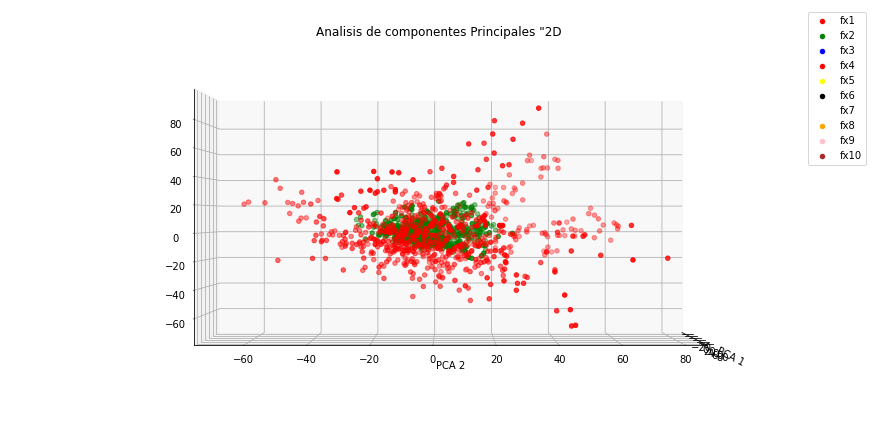

In [264]:
import matplotlib.pyplot as plt
from sklearn.decomposition import  PCA
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(1, figsize=(12, 6))
ax = Axes3D(fig,elev=-0, azim=0)
#X_reduced = PCA(n_components=3).fit_transform(X)

# create the PCA instance with the number of components to be computed 
pca = PCA(n_components= 3)

# "transform" the data that you want to reduce to "two components"
X_PCA = pca.fit_transform(latent[0])

ax.scatter3D(X_PCA[:689, 0], X_PCA[:689, 1],X_PCA[:689, 2], c='red', label='fx1')
ax.scatter3D(X_PCA[690:1379, 0], X_PCA[690:1379, 1],X_PCA[690:1379, 2], c='green', label='fx2')
ax.scatter3D(X_PCA[1380:2069, 0], X_PCA[1380:2069, 1],X_PCA[1380:2069, 2], c='blue', label='fx3')
ax.scatter3D(X_PCA[2070:2759, 0], X_PCA[2070:2759, 1],X_PCA[2070:2759, 2], c='red', label='fx4')
ax.scatter3D(X_PCA[2760:3449, 0], X_PCA[2760:3449, 1],X_PCA[2760:3449, 2], c='yellow', label='fx5')
ax.scatter3D(X_PCA[3450:4139, 0], X_PCA[3450:4139, 1],X_PCA[3450:4139, 2], c='black', label='fx6')
ax.scatter3D(X_PCA[4140:4829, 0], X_PCA[4140:4829, 1],X_PCA[4140:4829, 2], c='white', label='fx7')
ax.scatter3D(X_PCA[4830:5519, 0], X_PCA[4830:5519, 1],X_PCA[4830:5519, 2], c='orange', label='fx8')
ax.scatter3D(X_PCA[5520:6209, 0], X_PCA[5520:6209, 1],X_PCA[5520:6209, 2], c='pink', label='fx9')
ax.scatter3D(X_PCA[6210:6899, 0], X_PCA[6210:6899, 1],X_PCA[6210:6899, 2], c='brown', label='fx10')





#plt.scatter(X_PCA[400:599, 0], X_PCA[400:599, 1],X_PCA[:689, 2], c='blue', label='grain')
#plt.scatter(X_PCA[600:799, 0], X_PCA[600:799, 1], c='orange', label='res')
#plt.scatter(X_PCA[800:999, 0], X_PCA[800:999, 1], c='yellow', label='waveshapping')

plt.legend()
plt.title('Analisis de componentes Principales "2D')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

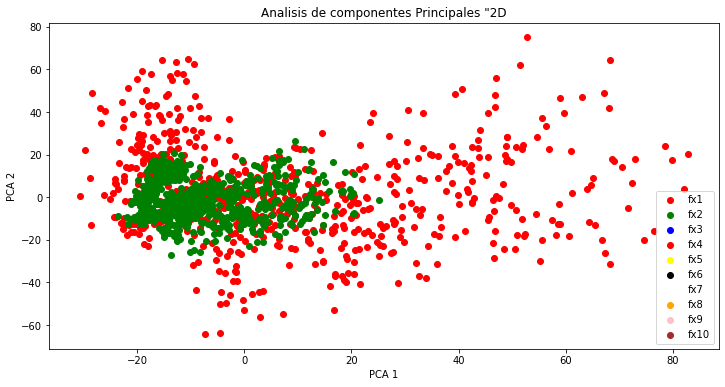

In [268]:
import matplotlib.pyplot as plt
from sklearn.decomposition import  PCA
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(1, figsize=(12, 6))
#ax = Axes3D(fig,elev=-0, azim=0)
#X_reduced = PCA(n_components=3).fit_transform(X)

# create the PCA instance with the number of components to be computed 
pca = PCA(n_components= 2)

# "transform" the data that you want to reduce to "two components"
X_PCA = pca.fit_transform(latent[0])

plt.scatter(X_PCA[:689, 0], X_PCA[:689, 1], c='red', label='fx1')
plt.scatter(X_PCA[690:1379, 0], X_PCA[690:1379, 1], c='green', label='fx2')
plt.scatter(X_PCA[1380:2069, 0], X_PCA[1380:2069, 1], c='blue', label='fx3')
plt.scatter(X_PCA[2070:2759, 0], X_PCA[2070:2759, 1], c='red', label='fx4')
plt.scatter(X_PCA[2760:3449, 0], X_PCA[2760:3449, 1], c='yellow', label='fx5')
plt.scatter(X_PCA[3450:4139, 0], X_PCA[3450:4139, 1], c='black', label='fx6')
plt.scatter(X_PCA[4140:4829, 0], X_PCA[4140:4829, 1], c='white', label='fx7')
plt.scatter(X_PCA[4830:5519, 0], X_PCA[4830:5519, 1], c='orange', label='fx8')
plt.scatter(X_PCA[5520:6209, 0], X_PCA[5520:6209, 1], c='pink', label='fx9')
plt.scatter(X_PCA[6210:6899, 0], X_PCA[6210:6899, 1], c='brown', label='fx10')





#plt.scatter(X_PCA[400:599, 0], X_PCA[400:599, 1],X_PCA[:689, 2], c='blue', label='grain')
#plt.scatter(X_PCA[600:799, 0], X_PCA[600:799, 1], c='orange', label='res')
#plt.scatter(X_PCA[800:999, 0], X_PCA[800:999, 1], c='yellow', label='waveshapping')

plt.legend()
plt.title('Analisis de componentes Principales "2D')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()